In [1]:
import torch
from torch import ones, zeros, tensor, eye

from torch.distributions import Categorical

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='white', palette='colorblind', color_codes=True)

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/control_dilemmas')])

In [2]:
from befit.simulate import Simulator
from befit.tasks import bandits
from befit.agents import AIBandits, BIBandits, Random

blocks = 120  # number of experimental blocks
trials = 5  # number of trials in each block
nsub = 100  # number of simulated subjects

nc = 3  #  number of contexts
no = 3  #  number of offers/stimuli configurations
nd = 20 #  max duration
ns = 3  #  number of arms
na = 3  #  number of choices
nf = 3  #  number of features (null, red, blue)

In [3]:
# Define environment
pr_c = torch.tensor([1., 0., 0.])

pr_co = eye(nc, no)

rho = .8
pr_pr = (1-rho)*ones(nc, ns, nf)/(nf - 1)
pr_pr[0, 0, 0] = rho
pr_pr[0, 1, 1] = rho
pr_pr[0, 2, 2] = rho

pr_pr /= pr_pr.sum(-1, keepdim=True)

priors = {'offers': pr_co,
          'locations': ones(na)/na,
          'probs': pr_pr}

pr_dcc = zeros(nd, nc, nc)
pr_dcc[0] = torch.tensor([[0., 1., 0.], [0., 0., 1.], [1., 0., 0.]])
pr_dcc[1:] = eye(nc).repeat(nd-1, 1, 1)

pr_cd = zeros(nc, nd)
pr_cd[:, -1] = 1.

pr_coo = eye(no).repeat(nc, 1, 1)
#pr_soo = .9*pr_soo + .1*(ones(no, no) - eye(no)).repeat(nc, 1, 1)/(no-1)

pr_all = eye(na).reshape(na, 1, na).repeat(1, na, 1)
transitions = {'locations': pr_all}

# generate sequence of contexts
context = []
duration = []
offers = []
for k in range(blocks):
    if k == 0:
        cnt = Categorical(probs=pr_c).sample()
        drt = Categorical(probs=pr_cd[cnt]).sample()
    else:
        cnt = context[-1].clone()
        drt =  duration[-1].clone()

        if drt == 0:
            cnt = Categorical(probs=pr_dcc[0, cnt]).sample()
            drt = Categorical(probs=pr_cd[cnt]).sample()
        else:
            drt -= 1

    context.append(cnt)
    duration.append(drt)
    
    off = zeros(trials, dtype=torch.long)
    for t in range(trials):
        if t == 0:
            off[t] = Categorical(probs=pr_co[cnt]).sample()
        else:
            off[t] = Categorical(probs=pr_coo[cnt, off[t-1]]).sample()
    
    offers.append(off.repeat(nsub, 1).transpose(dim0=1, dim1=0))

# generate probability of observing different arms for each offer-choice pairs
arm_types = torch.tensor([[0, 0, 1], 
                          [2, 1, 0], 
                          [2, 0, 0]])

pr_arms = eye(ns)[arm_types]

task = bandits.MultiArmedBandit(priors, 
                                transitions, 
                                context,
                                offers,
                                arm_types,
                                nsub=nsub, 
                                blocks=blocks, 
                                trials=trials)

In [4]:
# Define agents

pars = {
    'ns': ns,  # number of arm types
    'nl': na,  # number of locations/arms in each trial is the same as the number of actions
    'na': na,
    'no': no,
    'nc': nc,
    'nf': nf,
    'ni': nf,  # internal states change preference over features, for now they match number of features
}

a = 3*pr_arms.repeat(nsub, 1, 1, 1) + 1

ai_agent = AIBandits(pars, runs=nsub, blocks=blocks, trials=trials)
ai_agent.set_parameters(x = [a], depth=trials, lam=.2)


pars = {
    'ns': ns,  # number of arm types
    'nl': na,  # number of locations/arms in each trial is the same as the number of actions
    'na': na,
    'no': no,
    'nc': nc,
    'nf': nf,
    'ni': nf,  # internal states change preference over features, for now they match number of features
    'arm-types': (pr_arms, arm_types)
}

# a = (torch.eye(3) + ones(3, 3)).repeat(nsub, 1, 1)
bi_agent = BIBandits(pars, runs=nsub, blocks=blocks, trials=trials)
bi_agent.set_parameters(x=[a])

random_agent = Random(pars, runs=nsub, blocks=blocks, trials=trials)

In [5]:
sim1 = Simulator(task.initialise(), ai_agent, runs=nsub, blocks=blocks, trials=trials)
sim1.simulate_experiment()

# sim2 = Simulator(task.initialise(), bi_agent, runs=nsub, blocks=blocks, trials=trials)
# sim2.simulate_experiment()

sim3 = Simulator(task.initialise(), random_agent, runs=nsub, blocks=blocks, trials=trials)
sim3.simulate_experiment()

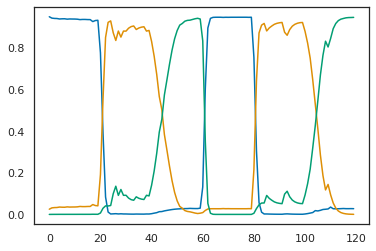

In [6]:
plt.plot(torch.stack(ai_agent.priors['context'][1:])[:, 10].numpy())

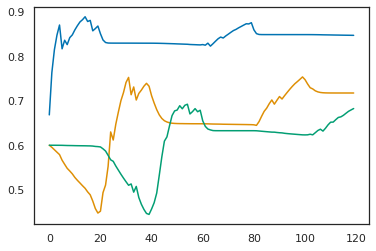

In [7]:
O = torch.stack(ai_agent.priors['offers'])[1:].reshape(blocks, trials, nsub, 3, 3)

mO = O/O.sum(-1, keepdim=True)
plt.plot(mO[:, -1, 0, range(3), range(3)].numpy())

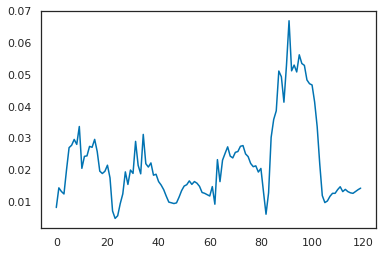

In [15]:
H_pi = - np.nan_to_num(ai_agent.beliefs['policies'] * ai_agent.beliefs['policies'].log()).sum(-1)
plt.plot(np.exp(-H_pi[:,0,0]))

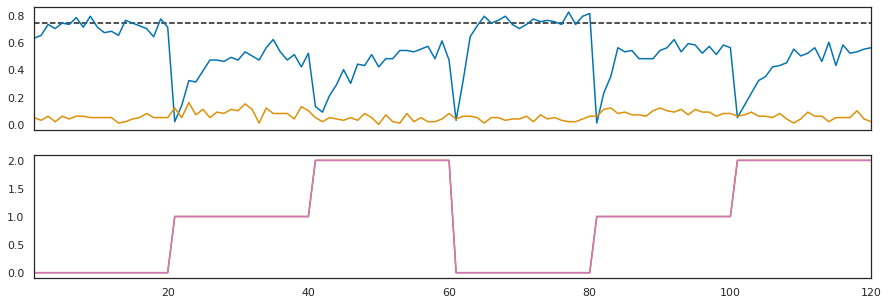

In [16]:
successes = []
for out1, out3 in zip(sim1.stimulus['outcomes'], sim3.stimulus['outcomes']):
    successes.append(torch.stack([out1[-1][-1], out3[-1][-1]], -1))
    
successes = torch.stack(successes)

maximum = rho**trials + rho**(trials - 1)*(1-rho)*trials

N = nsub//3
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
blks = torch.arange(1, blocks + 1).numpy()
axes[0].plot(blks, successes[..., 0].mean(-1).numpy());
# axes[0].plot(blks, successes[..., -2].mean(-1).numpy());
axes[0].plot(blks, successes[..., -1].mean(-1).numpy());
axes[0].hlines(maximum, 1, 500, 'k', linestyle='--')

axes[1].plot(blks, torch.stack(context).numpy(), 'r');
axes[1].plot(blks, torch.stack(offers)[:, 0, 0].numpy(), 'm');

plt.xlim([1, 120]);

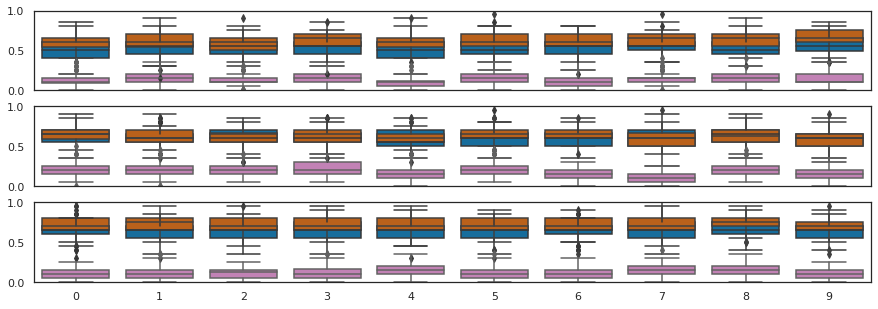

In [8]:
scc = successes.reshape(60, -1, nsub, 3)

fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharex=True, sharey=True)

exp_scc = {'ai': [], 'bi': [], 'rnd': []}
for i in range(scc.shape[1]):
    res = scc[:, i].reshape(20, -1, nsub, 3).mean(0)
    exp_scc['ai'].append(res[..., 0])
    exp_scc['bi'].append(res[..., 1])
    exp_scc['rnd'].append(res[..., 2])

for i in range(3):
    sns.boxplot(data=torch.stack(exp_scc['ai'])[:, i].numpy().T, ax=axes[i], color='b')
    sns.boxplot(data=torch.stack(exp_scc['bi'])[:, i].numpy().T, ax=axes[i], color='r')
    sns.boxplot(data=torch.stack(exp_scc['rnd'])[:, i].numpy().T, ax=axes[i], color='m')

plt.ylim([0, 1]);

(1, 100)

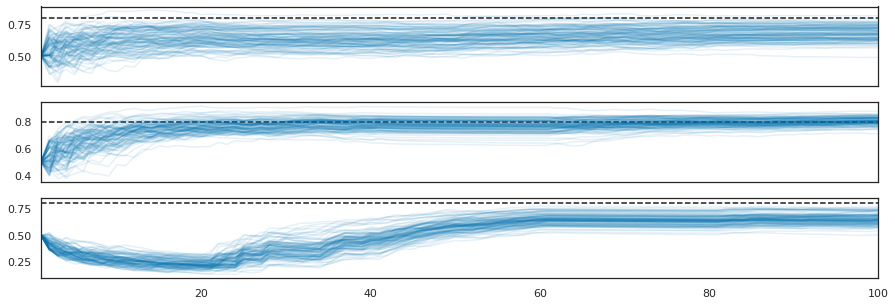

In [23]:
a = torch.stack(bi_agent.a[:-1]).reshape(blocks, trials, nsub, ns, nf)
A = a/a.sum(-1, keepdim=True)
A = A[:, 0, :, [0, 1, 2], [0, 1, 2]]

fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
for i in range(3):
    axes[i].plot( range(1, 601), A[..., i].numpy(), alpha=.1, color='b')
    axes[i].hlines(rho, 1, 600, 'k', linestyle='--')
plt.xlim(1, 100)
    

tensor(2) tensor(4)


tensor([2, 2, 2, 2, 2])

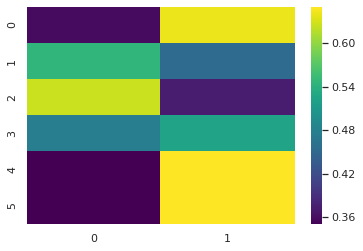

In [38]:
block = 41
sub = 5
sns.heatmap(ai_agent.beliefs['offers'][block, :, sub], cmap='viridis')
print(context[block], offers[block][0][sub])
torch.stack(sim1.responses[block][1:])[:, sub]

[tensor([0., 0., 1.]),
 tensor([1., 0., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 0., 1.]),
 tensor([0., 0., 1.])]

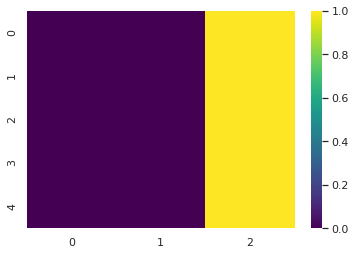

In [39]:
sns.heatmap(ai_agent.beliefs['locations'][block, :-1, sub], cmap='viridis')
[otc[0][sub] for otc in sim1.stimulus['outcomes'][block][1:]]

In [42]:
a = bi_agent.a[sub]
a/a.sum(-1, keepdim=True)

tensor([[0.5539, 0.2637, 0.1824],
        [0.1554, 0.4494, 0.3951],
        [0.3065, 0.1607, 0.5327]])

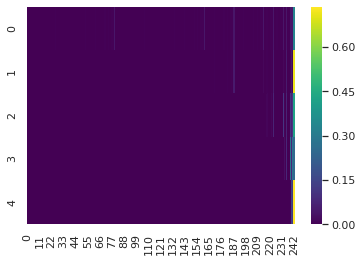

In [23]:
sns.heatmap(ai_agent.beliefs['policies'][block, :, sub], cmap='viridis')

tensor([0.0642, 0.0156, 0.9203])
tensor([0., 0., 1.])


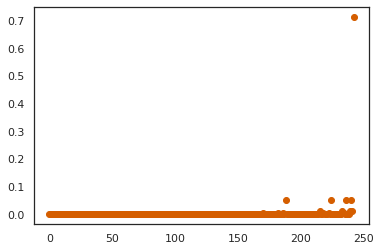

In [43]:
t = 1
plt.plot(ai_agent.beliefs['policies'][block, t, sub].numpy(), 'ro');

probs = ai_agent.beliefs['policies'][block, t, sub]
actions = ai_agent.policies[:, t]

pr_a = zeros(na)
for a in range(na):
    loc = actions == a
    pr_a[a] = probs[loc].sum()

print(pr_a)
print((pr_a.log()*100).softmax(-1))

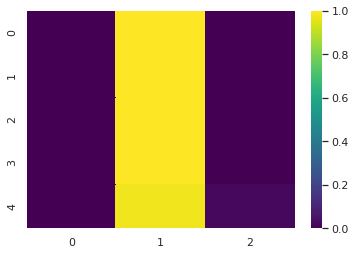

In [41]:
sns.heatmap(ai_agent.v[block, :, sub].softmax(-1), cmap='viridis')

In [46]:
a = torch.stack(ai_agent.a)[:-1].reshape(blocks, trials, -1, nc, 2, na, nf)[block, t, sub, 2]

ma = torch.einsum('ijk,i->jk', a / a.sum(-1, keepdim=True), ai_agent.beliefs['offers'][block, t-1, sub])
print(a)
print(ai_agent.beliefs['offers'][block, t-1, sub])
print(ma)
print(torch.einsum('ij,kj->ik', ai_agent.U[sub], ma))
post = (10*torch.einsum('ij,kj->ik', ai_agent.U[sub], ma)).reshape(-1).softmax(-1).reshape(3, 3)
print(post)

tensor([[[2.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 2.0000],
         [2.3925, 1.0000, 2.3325]],

        [[1.0000, 1.0000, 2.0000],
         [2.0000, 1.0000, 1.0000],
         [1.6075, 1.0000, 5.6675]]])
tensor([0.3584, 0.6416])
tensor([[0.3396, 0.2500, 0.4104],
        [0.4104, 0.2500, 0.3396],
        [0.2744, 0.1401, 0.5854]])
tensor([[-1.4378, -1.5794, -1.3075],
        [-1.4188, -1.5603, -1.0687],
        [-1.7395, -1.7395, -1.9593]])
tensor([[2.1437e-02, 5.2041e-03, 7.8954e-02],
        [2.5943e-02, 6.2981e-03, 8.5995e-01],
        [1.0492e-03, 1.0492e-03, 1.1658e-04]])


In [48]:
ai_agent.expectations['entropy'][block, t, t, sub] - ai_agent.expectations['ambiguity'][block, t, t, sub]

tensor([0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455,
        0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455,
        0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455,
        0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455,
        0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455,
        0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455,
        0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599,
        0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599,
        0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599, 0.1599,
        0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455,
        0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455,
        0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455,
        0.2455, 0.2455, 0.2455, 0.2455, 

In [49]:
ai_agent.beliefs['outcomes'][block, t+1, sub]

tensor([[0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.3396, 0.2500, 0.4104],
        [0.4104, 0.2500, 0.3396],
        [0.4104, 0.2500, 0.3396],
        [0.410

In [61]:
pr_pr[0] * 10

tensor([[8., 1., 1.],
        [1., 8., 1.],
        [1., 1., 8.]])